### Afshan Anam Saeed 21-741-954

# Assignment 7- Network Science
## Analysis of Financial Networks

In [1]:
import networkx as nx                           #for network analysis
import numpy as np                              #for mathematical analysis
import matplotlib.pyplot as plt                 #for visualization
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the datasets
hour_returns = np.load("C:\\Users\\Aqdus\\Downloads\\Data\\Data\\cormat_1h.npy")
minute_returns = np.load("C:\\Users\\Aqdus\\Downloads\\Data\\Data\\cormat_1m.npy")

### A07.1 - The Marčenko-Pastur law

In [3]:
def Marcenko(cormat,timeframe):
    #computing the eigen values and eigen vectors
    eigval, eigvec = np.linalg.eig(cormat)
    eigen_values=sorted(list(eigval))
    
    print("The market value is: ",max(eigval))
    
    #computing the Marčenko-Pastur law values
    if timeframe=="hourly":
        Q=3.6289
    elif timeframe=="minute":
        Q=200.8969
    else:
        pass
    
    lam_min = 1 + 1/Q - 2*np.sqrt(1/Q)        # computing λ_min
    lam_max = 1 + 1/Q + 2*np.sqrt(1/Q)        # computing λ_max 
    
    mp_dist={}
    for lam in eigen_values:
        if lam<lam_min or lam>lam_max:
            mp_dist[lam]=0
        else:
            mp_dist[lam]=(Q*np.sqrt((lam_max-lam)*(lam-lam_min)))/(2*math.pi*lam)

    #plotting the histogram
    plt.figure(figsize=(7,7))
    plt.hist(eigval,color="b",bins = 100, density=True, label="Emperical")
    plt.plot(mp_dist.keys(),mp_dist.values(),color="r",label="MP Law")
    plt.legend()
    plt.xlabel("Eigen Values")
    plt.ylabel("Count")
    plt.title("A diagram depicting the Eigen Value Distribution for the "+timeframe+" returns")
    plt.show()
    
    #computing the denoised correlations
    C = (len(eigval) - sum(eigval[eigval >= lam_max]))/(len(eigval[eigval < lam_max]))
    eigval[eigval < lam_max] = C
    Y =  np.dot(eigvec, np.dot(np.diag(eigval), np.linalg.inv(eigvec)))
    D = np.diagonal(Y)
    D = 1/np.sqrt(D)
    D = np.diag(D)
            
    # rescale to have unit diagonal by doing Y = DYD
    Y = np.dot(D, np.dot(Y,D))
    return Y

The market value is:  31.02783573849156


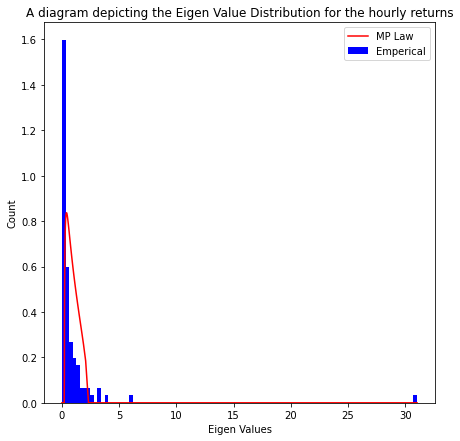

In [4]:
cormat_hour=Marcenko(hour_returns,"hourly")

The market value is:  30.15967998949909


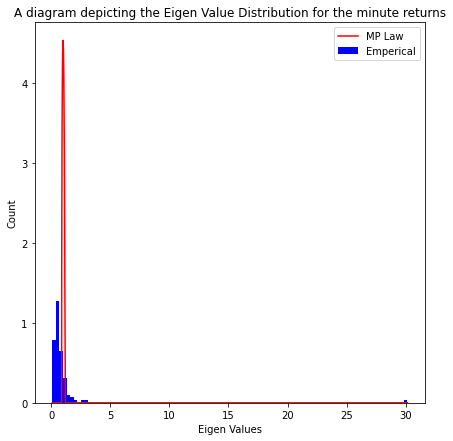

In [5]:
cormat_minute=Marcenko(minute_returns,"minute")

### A07.2 - Correlation MSTs

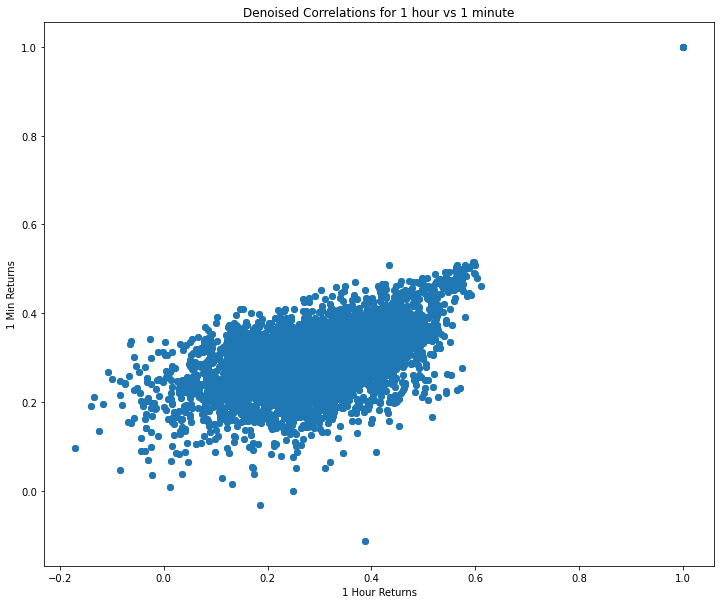

In [6]:
#correlation matrix for hour vs minute timescale stocks
plt.figure(figsize = (12,10))
plt.scatter(cormat_hour, cormat_minute)
plt.title('Denoised Correlations for 1 hour vs 1 minute')
plt.xlabel('1 Hour Returns')
plt.ylabel('1 Min Returns')
plt.show()

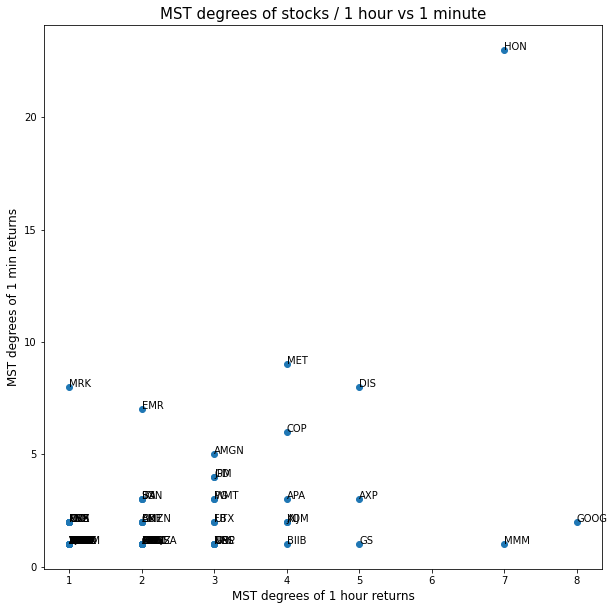

In [7]:
matrices = [cormat_hour,cormat_minute]

# Opening Stocknames file and adding then to the dictionary 
name_file = open("C:\\Users\\Aqdus\\Downloads\\Data\\Data\\stocknames.txt", 'r')
lines = name_file.readlines()
names={}                             
name = {}                             #for node names
D=[]                                  #for filtered correlation values
graphs=[]                             #for graphs

#getting node names
for i in range(len(lines)):
    names[i] = lines[i]
    name[i] = names[i].rstrip('\n')

deg_list = []
for i in matrices:        
    
    # Filtering correlations
    d_ij = np.sqrt(2*(1 - i))    # filtered correlation matrix / 𝑑𝑖𝑗 = √2(1 − 𝑟𝑖𝑗)
    d_ij = np.nan_to_num(d_ij)   # convert all Nan values to 0
    D.append(d_ij)
        
    Graph = nx.from_numpy_matrix(d_ij)                # creating a graph from filterred matrix d_ij
    nx.set_node_attributes(Graph, name, 'name')       # assigning tickers to the nodes
    MST = nx.minimum_spanning_tree(Graph)             # building MST
    graphs.append(MST)
        
    deg = []
    for d in MST.degree(): deg.append(d[1])      # list of degrees
    deg_list.append(deg)

#plotting the graph
plt.figure(figsize = (10,10))
plt.scatter(deg_list[0], deg_list[1])
for i, nm in enumerate(name):
    plt.annotate(name[i],(deg_list[0][i],deg_list[1][i]))
plt.title('MST degrees of stocks / 1 hour vs 1 minute', fontsize = 15)
plt.xlabel('MST degrees of 1 hour returns', fontsize = 12)
plt.ylabel('MST degrees of 1 min returns', fontsize = 12)
plt.show()
print()

#### Conclusions

<b> Is there a market Mode? </b>

The Market Mode is defined as the maximum eigen value obtained in a market set. In the above function "Marcenko", we recieved an output of the Market Mode being 31.03 for the hourly returns and 30.16 for the minute returns of our NYSE datasets. Thus, YES, the Market Mode exists for the dataset.

<b> Which is the stock that has the strongest relation with the market? </b>

In [8]:
Value=["hourly","minute"]
for i in range(2):
    Eig_Val, Eig_Vec = np.linalg.eig(D[i])
    strong_node = names[np.argmax(np.absolute(Eig_Vec[np.argmax(Eig_Val)]))]
    print('Stock that has the strongest relation with the market after',Value[i],'returns: ', strong_node)

Stock that has the strongest relation with the market after hourly returns:  CAT

Stock that has the strongest relation with the market after minute returns:  GM



<b> Which are the 5 stocks with highest degree on the MST? </b>

In [9]:
for i in range(2):
    d = dict(graphs[i].degree())
    top_5_degree = sorted(d, key=d.get, reverse=True)[:5]
    
    for key, val in d.items():
        if val == d[top_5_degree[4]]: # compare if other stocks have same degrees as lowest of top 5 degrees
            if key not in top_5_degree: top_5_degree.append(key)
    print('Stocks with five highest degree on MST of', Value[i], 'returns are:')
    # loop to print tickers with highest degrees
    for t in top_5_degree:
        print('Degree of', (nx.get_node_attributes(graphs[i], 'name'))[t] , ' : ' , graphs[i].degree()[t])

Stocks with five highest degree on MST of hourly returns are:
Degree of GOOG  :  8
Degree of HON  :  7
Degree of MMM  :  7
Degree of AXP  :  5
Degree of DIS  :  5
Degree of GS  :  5
Stocks with five highest degree on MST of minute returns are:
Degree of HON  :  23
Degree of MET  :  9
Degree of DIS  :  8
Degree of MRK  :  8
Degree of EMR  :  7


<b> Is the degree distribution of MSTs qualitatively the same at 1 minute and 1 hour? </b>

As observed from above, we have different stocks that show highest degrees after 1 hour and 1 minute. Thus, high degree distribution at the hourly rate does not imply a high degree distribution at the minutely rate. 